# Clustering documents


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from hdbscan import hdbscan
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.model_selection import train_test_split
import hdbscan
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec, FastText
from sklearn.decomposition import PCA
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

In [4]:
# --------------------------- Load the two datasets -------------------------


# Load BBC news data ----------------------------------------
data_url = 'https://raw.githubusercontent.com/Alex-Kout/Clustering_News_Articles/refs/heads/main/data/bbc_news_test.csv'
bbc_df = pd.read_csv(data_url)
texts_bbc = bbc_df.Text
labels_bbc = bbc_df.Category.astype('category').cat.codes.values
n_clusters_bbc = bbc_df.Category.nunique()


# Load 20newsgroup data ----------------------------------------
data_20newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
documents_20newsgroups = data_20newsgroups.data
labels_20newsgroups = data_20newsgroups.target
labels_names_20newsgroups = data_20newsgroups.target_names
news_dict = {
    'label': labels_20newsgroups,
    'comment': documents_20newsgroups,
}
news_df = pd.DataFrame(news_dict)
news_df['label_name'] = news_df['label'].apply(lambda x: labels_names_20newsgroups[x])

_, x_test_news, _, y_test_news = train_test_split(
    news_df,
    news_df['label'],
    test_size=0.1,
    random_state=42,
    stratify=news_df['label']
)

# we will use the x_test data
news_df = x_test_news
texts_20 = x_test_news.comment
labels_20 = x_test_news.label_name
n_clusters_20 = x_test_news.label_name.nunique()



### Exploratory analsyis

BBC articles statistics: 
count    1490.000000
mean      385.012752
std       210.898616
min        90.000000
25%       253.000000
50%       337.000000
75%       468.750000
max      3345.000000
Name: Text, dtype: float64


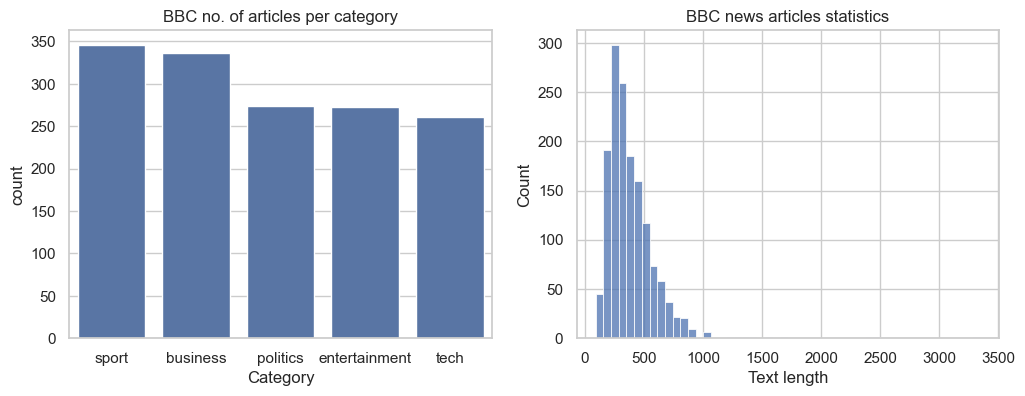

In [251]:
# EDA for BBC news articles

print('BBC articles statistics: ')
print(f'{texts_bbc.str.split().str.len().describe()}')

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(bbc_df.Category.value_counts(), ax = axes[0])
axes[0].set_title('BBC no. of articles per category')

sns.histplot(texts_bbc.str.split().str.len(), bins = 50, ax =axes[1])
axes[1].set_title('BBC news articles statistics')
plt.xlabel('Text length')
plt.show()



BBC articles statistics: 
count     1885.00000
mean       182.67321
std        555.12058
min          0.00000
25%         40.00000
50%         82.00000
75%        165.00000
max      10297.00000
Name: comment, dtype: float64


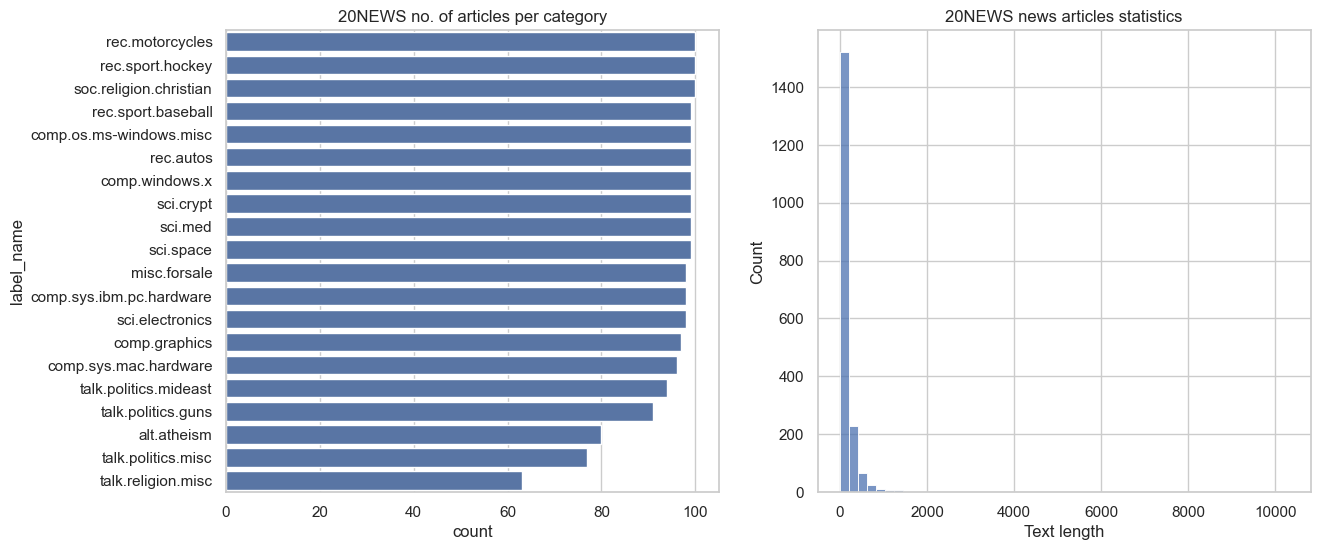

In [252]:
# EDA for 20NEWS news

print('BBC articles statistics: ')
print(f'{texts_20.str.split().str.len().describe()}')

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(x_test_news.label_name.value_counts(), ax = axes[0], orient='h')
axes[0].set_title('20NEWS no. of articles per category')

sns.histplot(texts_20.str.split().str.len(), bins = 50, ax =axes[1])
axes[1].set_title('20NEWS news articles statistics')
plt.xlabel('Text length')
plt.show()




### Modeling

In [253]:
# Here we will create our main class that has all the functions and also
# a running function to complete the project directly quickly and in a clean way

class TextClustering:
    """
    This class contains al the functions for embedding, dimensionality reduction, clustering and evaluation
    """

    def __init__(self):
        pass

    # -------------------- Feature extraction --------------------

    def tf_idf(self, texts, max_features = 5000):
        """ Transforms the text using tf-idf
        Params:
            texts: the texts
            max_features: max size for tf-idf
        Returns:
            teh matrix
            """
        vectorizer = TfidfVectorizer(max_features = max_features)
        tfidf_matrix = vectorizer.fit_transform(texts)
        return tfidf_matrix.toarray()

    def word2vec(self, texts, vector_size = 100):
        """ Generates embeddings using word2vec
        Params:
            texts: the texts
            vector_size: dimensions of word2vec
        Returns:
            the matrix
            """
        tokenized = [t.split() for t in texts]
        word2vec = Word2Vec(tokenized, vector_size = vector_size, window = 5, min_count = 2)
        word2vec = np.array([np.mean([word2vec.wv[word] for word in doc if word in word2vec.wv] or [np.zeros(vector_size)], axis = 0) for doc in tokenized])
        return word2vec

    def fast_text(self, texts, vector_size = 100):
        """ Generates embeddings using FastText
        Params:
            texts: the texts
            vector_size: dimensions of word2vec
        Returns:
            the matrix
            """
        tokenized = [t.split() for t in texts]
        fastext = FastText(tokenized, vector_size = vector_size, window = 5, min_count = 2)
        fastext = np.array([np.mean([fastext.wv[word] for word in doc if word in fastext.wv] or [np.zeros(vector_size)], axis = 0) for doc in tokenized])
        return fastext

    # -------------------- Dimensionality reduction --------------------

    def dimensionality_reduction(self, x, n_components = 50):
        """
        Reduces the dimensions for better clustering
        Params:
            x = data
            n_components: number of components to keep
        Returns:
            the reduced dimensions data
        """
        pca = PCA(n_components = n_components, random_state = 42).fit_transform(x)
        return pca

    # -------------------- Clustering --------------------

    def kmeans_cluster(self, x, n_clusters, random_state = 42):
        """ A Function to cluster with kmeans algorithm
        Params:
            x = data
            n_culsters: number of clusters
        Returns:
            the predictions
        """
        predictions = KMeans(n_clusters = n_clusters, random_state = random_state).fit_predict(x)
        return predictions

    def agglomerative_cluster(self, x, n_clusters):
        """ A Function to cluster with Agglomerative algorithm
        Params:
            x = data
            n_culsters: number of clusters
        Returns:
            the predictions
        """
        predictions = AgglomerativeClustering(n_clusters = n_clusters).fit_predict(x)
        return predictions

    def hdbscan_cluster(self, x, min_cluster_size = 15):
        """ A Function to cluster with HDBSCAM
        Params:
            x = data
            min_cluster_size = min num to form a cluster
        Returns:
            the predictions
        """
        predictions = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size).fit_predict(x)
        return predictions


    # -------------------- Evaluation --------------------

    def elbow(self, x, max_k = 20, title = ""):
        """
        This functions finds optimal cluster numbers using the ebow method
        """
        results = []
        C = range(1, max_k + 1)
        for c in C:
            kmeanModel = KMeans(n_clusters = c, random_state = 42, n_init = 10)
            kmeanModel.fit(x)
            results.append(kmeanModel.inertia_)

        plt.figure(figsize=(8, 5))
        plt.plot(C, results, 'bx-')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Inertia')
        plt.title(f'{title}: Optimal no. of clusters')
        plt.show()


    def evaluation(self, y_true, y_pred, x = None):
        """ This function will evaluate the results of clustering
        Params:
            y_true: true labels
            y_pred: predicted labels
        Returns:
            a dictionary with the results
        """
        results = {
            'NMI': normalized_mutual_info_score(y_true, y_pred),
            'ARI': adjusted_rand_score(y_true, y_pred),
            'AMI': adjusted_mutual_info_score(y_true, y_pred)}

        if x is not None:
            mask = y_pred != -1
            unique_labels = np.unique(y_pred[mask])

            if len(unique_labels) > 1:
                score = silhouette_score(x[mask], y_pred[mask])
                results['Silhouette'] = score
            else:
                results['Silhouette'] = 0
        return results


    def plot_tsne(self, x, labels, title, figsize = (12, 8)):
        """
        This function visualize the clusters in 2D space
        Params:
            labels: the cluster labels
            title: the title of the figure
        Returns:
            The plot
        """

        tsne = TSNE(n_components = 2, random_state = 42, init = 'pca')
        z = tsne.fit_transform(x)
        plt.figure(figsize = figsize)
        sns.scatterplot(x = z[:,0], y = z[:,1], hue = labels, s = 10)
        plt.title(title)
        plt.show()
    # -------------------- Run the whole project --------------------

    def run(self,texts, labels, n_clusters, dataset_name, n_components = 50):
        """ This function will run tf-idf, word2vec, fast text, pca and make clustering with all algorithms.
            Will return the results
            Params:
                texts: the texts
                labels: the labels
                n_clusters: the number of clusters
                dataset_name: the name of the dataset
                n_components: the number of components for pca
        """

        results = []

        # ------------ Ready for clustering and evaluation for each algorithm ------------

        # ----------   TF-IDF --------------
        print(f'{dataset_name} with TF-IDF:')
        texts_tf = self.tf_idf(texts)
        texts_tf_pca = self.dimensionality_reduction(texts_tf, n_components = n_components)

        # KMEANS
        pred_kmeans = self.kmeans_cluster(texts_tf_pca, n_clusters)
        eval_km = self.evaluation(labels, pred_kmeans, x = texts_tf_pca)
        eval_km.update({'Dataset': dataset_name, 'Embedding': 'TF-IDF', 'Algorithm': 'KMeans'})
        results.append(eval_km)

        # Agglomerative
        pred_agg = self.agglomerative_cluster(texts_tf_pca, n_clusters)
        eval_agg = self.evaluation(labels, pred_agg, x = texts_tf_pca)
        eval_agg.update({'Dataset': dataset_name, 'Embedding': 'TF-IDF', 'Algorithm': 'Agglomerative'})
        results.append(eval_agg)

        # HDBSCAN
        pred_hdb = self.hdbscan_cluster(texts_tf_pca)
        eval_hdb = self.evaluation(labels, pred_hdb, x = texts_tf_pca)
        eval_hdb.update({'Dataset': dataset_name, 'Embedding': 'TF-IDF', 'Algorithm': 'HDBSCAN'})
        results.append(eval_hdb)


        # ----------   WORD2VEC --------------

        print(f"Running {dataset_name} with Word2Vec...")
        texts_w2v = self.word2vec(texts)
        texts_w2v_pca = self.dimensionality_reduction(texts_w2v, n_components = n_components)

        # K-Means
        pred_km = self.kmeans_cluster(texts_w2v_pca, n_clusters)
        eval_km = self.evaluation(labels, pred_km, x = texts_w2v_pca)
        eval_km.update({'Dataset': dataset_name, 'Embedding': 'Word2Vec', 'Algorithm': 'KMeans'})
        results.append(eval_km)

        # Agglomerative
        pred_agg = self.agglomerative_cluster(texts_w2v_pca, n_clusters)
        eval_agg = self.evaluation(labels, pred_agg, x = texts_w2v_pca)
        eval_agg.update({'Dataset': dataset_name, 'Embedding': 'Word2Vec', 'Algorithm': 'Agglomerative'})
        results.append(eval_agg)

        # HDBSCAN
        pred_hdb = self.hdbscan_cluster(texts_w2v_pca)
        eval_hdb = self.evaluation(labels, pred_hdb, x = texts_w2v_pca)
        eval_hdb.update({'Dataset': dataset_name, 'Embedding': 'Word2Vec', 'Algorithm': 'HDBSCAN'})
        results.append(eval_hdb)

        # ----------   FAST TEXT --------------

        print(f"Running {dataset_name} with FastText...")
        texts_ft = self.fast_text(texts)
        texts_ft_pca = self.dimensionality_reduction(texts_ft, n_components = n_components)

        # K-Means
        pred_km = self.kmeans_cluster(texts_ft_pca, n_clusters)
        eval_km = self.evaluation(labels, pred_km, x = texts_ft_pca)
        eval_km.update({'Dataset': dataset_name, 'Embedding': 'FastText', 'Algorithm': 'KMeans'})
        results.append(eval_km)

        # Agglomerative
        pred_agg = self.agglomerative_cluster(texts_ft_pca, n_clusters)
        eval_agg = self.evaluation(labels, pred_agg, x = texts_ft_pca)
        eval_agg.update({'Dataset': dataset_name, 'Embedding': 'FastText', 'Algorithm': 'Agglomerative'})
        results.append(eval_agg)

        # HDBSCAN
        pred_hdb = self.hdbscan_cluster(texts_ft_pca)
        eval_hdb = self.evaluation(labels, pred_hdb, x = texts_ft_pca)
        eval_hdb.update({'Dataset': dataset_name, 'Embedding': 'FastText', 'Algorithm': 'HDBSCAN'})
        results.append(eval_hdb)

        return pd.DataFrame(results)

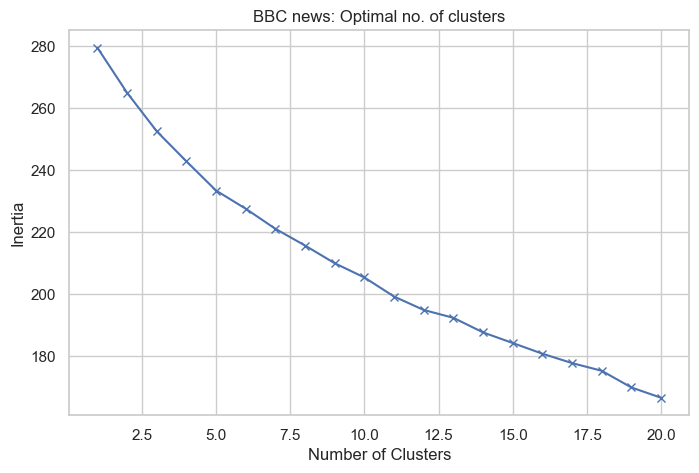

In [254]:
# Let's find the optimal num of clusters for BBC

model = TextClustering()
x_tfidf = model.tf_idf(texts_bbc)
x_pca = model.dimensionality_reduction(x_tfidf, n_components = 50)

model.elbow(x_pca, max_k=20, title='BBC news')

# We can see that the optimal no. of clusters is: 5.
# By adding more clusters, the marginal decrease is very low

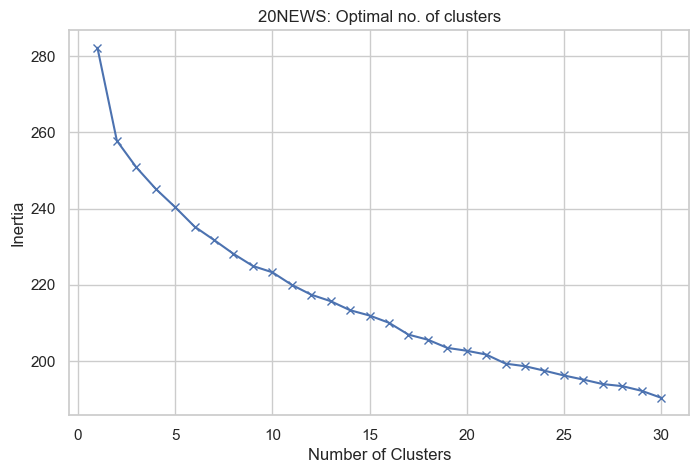

In [255]:
# Let's find the optimal num of clusters for 20NEWS

model = TextClustering()
x_tfidf = model.tf_idf(texts_20)
x_pca = model.dimensionality_reduction(x_tfidf, n_components = 50)

model.elbow(x_pca, max_k = 30, title = '20NEWS')

# here we can see that there is a bend around 5 and 10 clusters, but it doesn t have a significant drop at 20 clusters.
# Maybe there are many similar categories and the models will struggle a bit

In [256]:
# Initialize our main class and run the models
model = TextClustering()

# BBC clustering
print("Starting BBC clustering...")
bbc_results = model.run(texts_bbc, labels_bbc, n_clusters_bbc, "BBC News", n_components = 100)
bbc_results = pd.DataFrame(bbc_results)

# 20NewsGroups clustering
print("\nStarting 20NewsGroups clustering...")
news20_results = model.run(texts_20, labels_20, n_clusters_20, "20NewsGroups", n_components = 100)
news20_results = pd.DataFrame(news20_results)

print('\nBBC results:')
display(bbc_results)
print('\n20NewsGroups results:')
display(news20_results)


Starting BBC clustering...
BBC News with TF-IDF:
Running BBC News with Word2Vec...
Running BBC News with FastText...

Starting 20NewsGroups clustering...
20NewsGroups with TF-IDF:
Running 20NewsGroups with Word2Vec...
Running 20NewsGroups with FastText...

BBC results:


,NMI,ARI,AMI,Silhouette,Dataset,Embedding,Algorithm
0,0.641845,0.554449,0.640590,0.037923,BBC News,TF-IDF,KMeans
1,0.570303,0.450671,0.568791,0.042554,BBC News,TF-IDF,Agglomerative
2,0.000000,0.000000,0.000000,0.000000,BBC News,TF-IDF,HDBSCAN
3,0.395993,0.363694,0.393943,0.223021,BBC News,Word2Vec,KMeans
4,0.412192,0.359820,0.410166,0.196980,BBC News,Word2Vec,Agglomerative
5,0.000000,0.000000,0.000000,0.000000,BBC News,Word2Vec,HDBSCAN
6,0.249010,0.194362,0.246437,0.240454,BBC News,FastText,KMeans
7,0.267683,0.220564,0.265184,0.212029,BBC News,FastText,Agglomerative
8,0.000000,0.000000,0.000000,0.000000,BBC News,FastText,HDBSCAN



20NewsGroups results:


,NMI,ARI,AMI,Silhouette,Dataset,Embedding,Algorithm
0,0.207209,0.047968,0.176702,0.030212,20NewsGroups,TF-IDF,KMeans
1,0.200599,0.039249,0.168810,0.022776,20NewsGroups,TF-IDF,Agglomerative
2,0.000000,0.000000,0.000000,0.000000,20NewsGroups,TF-IDF,HDBSCAN
3,0.061845,0.006740,0.028672,0.188132,20NewsGroups,Word2Vec,KMeans
4,0.056444,0.005438,0.022866,0.147766,20NewsGroups,Word2Vec,Agglomerative
5,0.008878,-0.000128,0.001982,0.800882,20NewsGroups,Word2Vec,HDBSCAN
6,0.063308,0.007898,0.030278,0.216475,20NewsGroups,FastText,KMeans
7,0.057933,0.005814,0.025148,0.163385,20NewsGroups,FastText,Agglomerative
8,0.008010,-0.000124,0.000860,0.788897,20NewsGroups,FastText,HDBSCAN


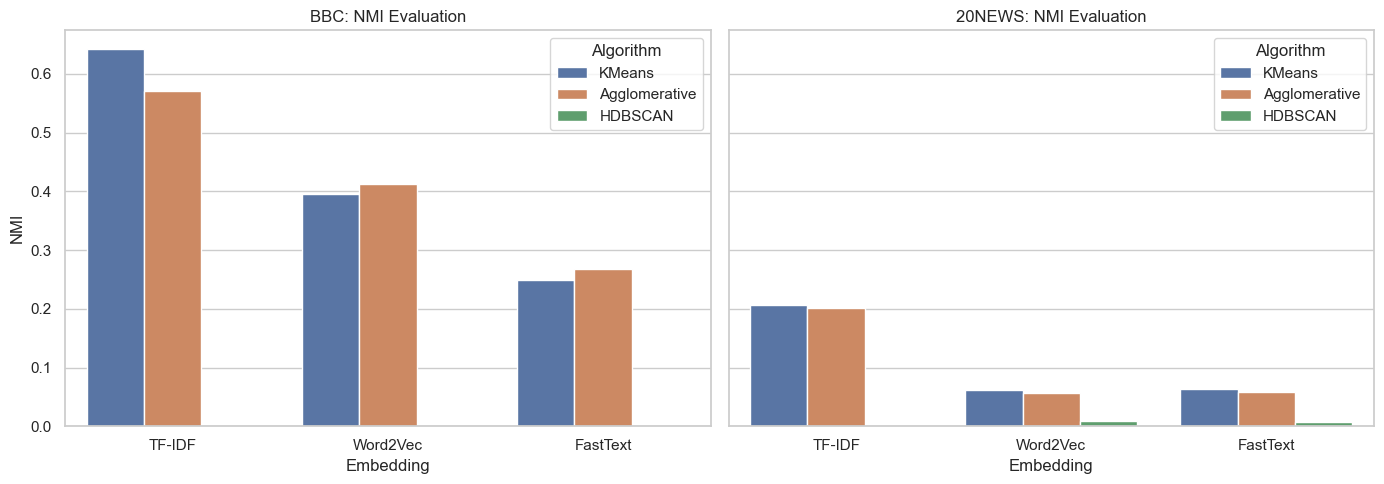

In [257]:
# Let's plot to see the results of each dataset
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

sns.barplot(data = bbc_results, x = 'Embedding', y = 'NMI', hue = 'Algorithm', ax = axes[0])
axes[0].set_title('BBC: NMI Evaluation')
axes[0].set_ylabel('NMI')

sns.barplot(data = news20_results, x = 'Embedding', y = 'NMI', hue = 'Algorithm', ax = axes[1])
axes[1].set_title('20NEWS: NMI Evaluation')
axes[1].set_ylabel('NMI')

plt.tight_layout()
plt.show()


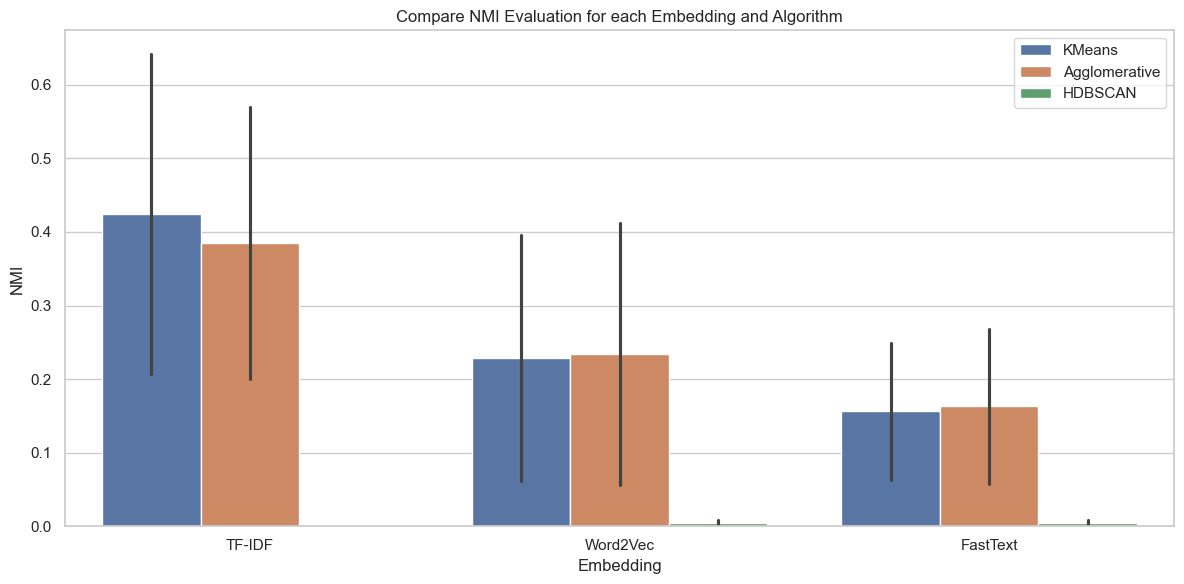

,NMI,ARI,AMI,Silhouette,Dataset,Embedding,Algorithm
0,0.641845,0.554449,0.640590,0.037923,BBC News,TF-IDF,KMeans
1,0.570303,0.450671,0.568791,0.042554,BBC News,TF-IDF,Agglomerative
2,0.000000,0.000000,0.000000,0.000000,BBC News,TF-IDF,HDBSCAN
3,0.395993,0.363694,0.393943,0.223021,BBC News,Word2Vec,KMeans
4,0.412192,0.359820,0.410166,0.196980,BBC News,Word2Vec,Agglomerative
5,0.000000,0.000000,0.000000,0.000000,BBC News,Word2Vec,HDBSCAN
6,0.249010,0.194362,0.246437,0.240454,BBC News,FastText,KMeans
7,0.267683,0.220564,0.265184,0.212029,BBC News,FastText,Agglomerative
8,0.000000,0.000000,0.000000,0.000000,BBC News,FastText,HDBSCAN
0,0.207209,0.047968,0.176702,0.030212,20NewsGroups,TF-IDF,KMeans


In [258]:
# Now let's plot to see the combined results
# Combine the results
all_results = pd.concat([bbc_results, news20_results])

# Let's visualize the see the results
plt.figure(figsize = (12, 6))
sns.barplot(data = all_results, x = 'Embedding', y = 'NMI', hue = 'Algorithm')
plt.title('Compare NMI Evaluation for each Embedding and Algorithm')
plt.legend(loc = 'upper right')
plt.tight_layout()
plt.show()

# Print the combined results
display(all_results)

BBC News with TF-IDF:
Running BBC News with Word2Vec...
Running BBC News with FastText...


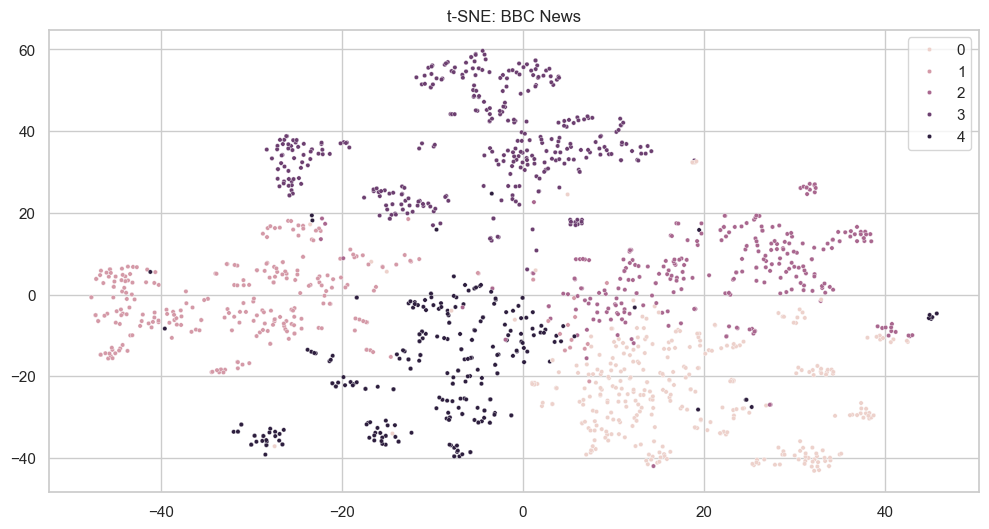

In [259]:
# Let's visualize the cluster in 2 Dimensional space
sns.set_theme(style = "whitegrid")

model = TextClustering()
bbc_results = model.run(texts_bbc, labels_bbc, 5, "BBC News")

bbc = model.tf_idf(texts_bbc)
bbc_pca = model.dimensionality_reduction(bbc, n_components = 50)
model.plot_tsne(bbc_pca, labels_bbc, "t-SNE: BBC News", figsize = (12, 6))

20 News with TF-IDF:
Running 20 News with Word2Vec...
Running 20 News with FastText...


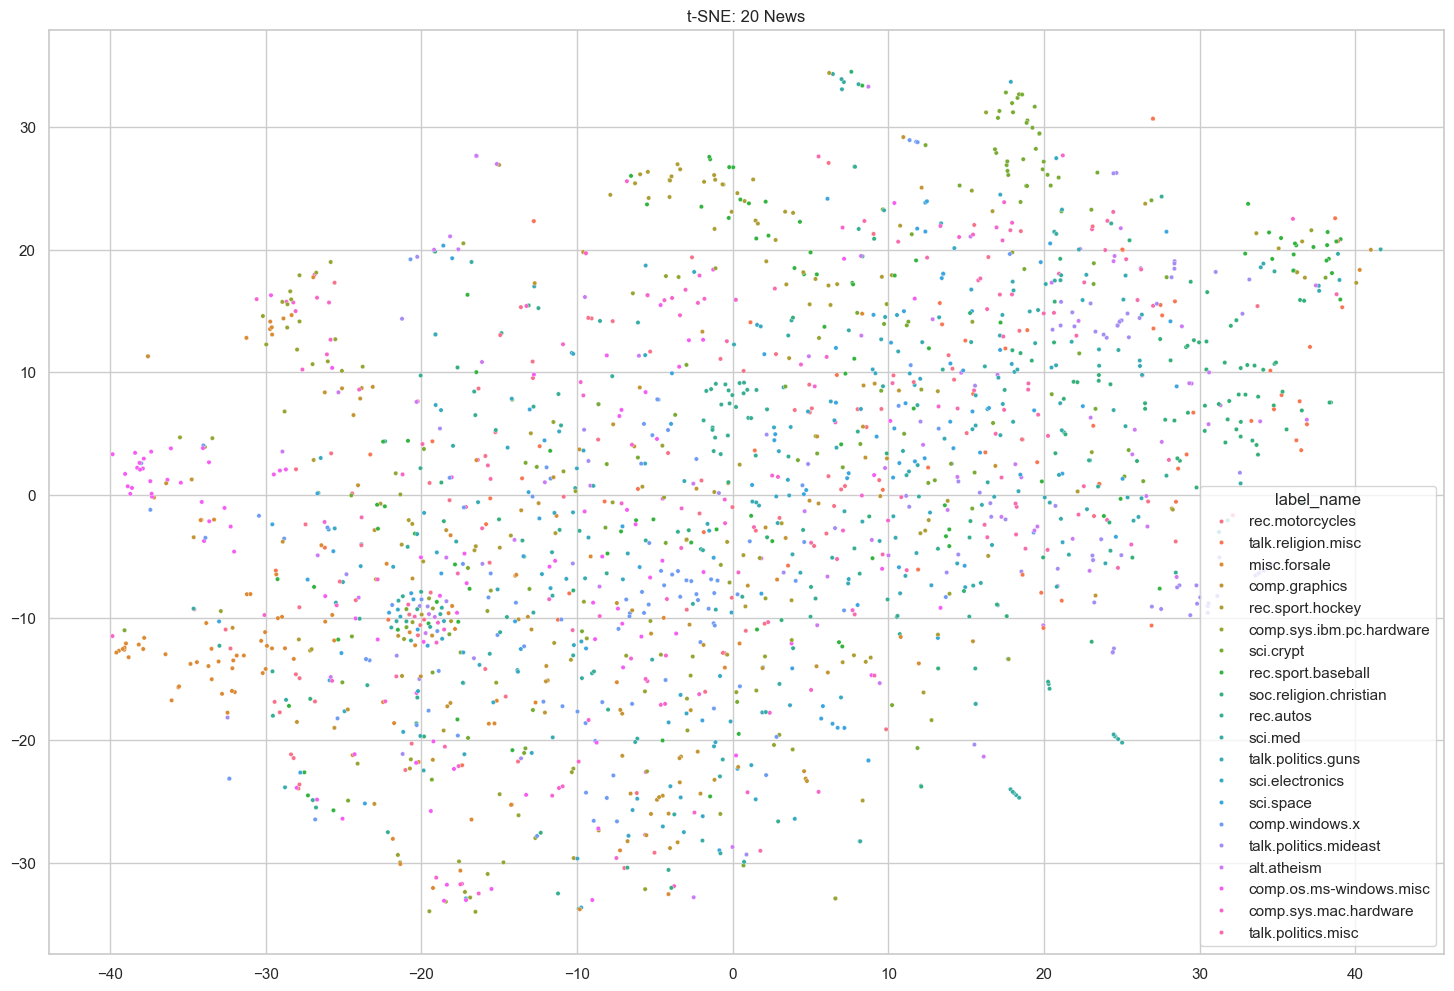

In [260]:
# Let's visualize the cluster in 2 Dimensional space
sns.set_theme(style = "whitegrid")

model = TextClustering()
news20_results = model.run(texts_20, labels_20, 20, "20 News")

news20 = model.tf_idf(texts_20)
news20_pca = model.dimensionality_reduction(news20, n_components = 50)
model.plot_tsne(news20_pca, labels_20, "t-SNE: 20 News", figsize = (18, 12))

## Summary
   * BBC news is a good structured dataset with balanced categories. The scores show that there are good distinctions of the vocabulary between the different categories
   * 20NewsGroup is a bit more complex dataset with many different categories. Many of those categories overlap resulting to lower predictability
   * The best embedding method was TF-IDF in both datasets, which means that specific keywords are more effective than semantic averages
   * On the other hand Word2Vec and FastText has lower NIM but higher Silhouette scores, creating more dense and tight clusters
   * The best prediction algorithm was K-Means in all metrics
   * HDBSCAN was almost crashed, probably because he was labeling most text as noise. Although, his Silhouette score was very good
   * For dimensionality reduction, after trying different numbers, the models worked better to low dimensions, around 10 - 50


# Conclusion:
## The most predictive model was K-Means, with PCA (10 - 50 dimensions) and TF-IDF for feature extraction
